# Programming with `geoh5` (ANALYST API)


This section provides examples on how to interact with Geoscience ANALYST
programmatically by using the geoh5 API [geoh5py](https://geoh5py.readthedocs.io/en/stable/). We are going to demonstrate how to

- Create/open a geoh5 workspace
- Access objects and data
- Use third-party packages to create and plot data

Let's get started with some imports.

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np

from geoh5py.data import Data
from geoh5py.objects import Points, ObjectBase
from geoh5py.workspace import Workspace

## Open/create a Workspace

The main element controlling the hierarchy of a `geoh5` is the `Workspace`. It is the class responsible for accessing information on disk and to register and create the various entities (groups, objects, data).

There are two ways to create or connect to an existing `geoh5` file through the `Workspace`.

### Option 1: Context manager

The `Workspace` class can open a file as a context manager using the `with`
statement. Just like any other [function](functions), everything after the `:`
must be indented to be part of the scope. This is the **preferred** method to
interact with the `geoh5` to make sure that the file gets closed at the end of
the context, even if the code has to exit premarturely due to error.

In [2]:
with Workspace("../assets/suncity.geoh5") as workspace:
    print(workspace.geoh5)

<HDF5 file "suncity.geoh5" (mode r+)>


### Option 2: `open()` and `close()`

The second option is to directly instantiate the Workspace or to call the `open()` method.

In [3]:
workspace.open()
print(workspace.geoh5)

<HDF5 file "suncity.geoh5" (mode r+)>


With this option, Python keeps a connection to the file until the `close()`
method gets called. This is sometimes preferable if the computations take a
long time or if you want to prevent other programs to access the file while your program is operating on it.

We are going to leave the workspace open for now, and remember to close it at the end.

## Objects and data

When connecting to an existing `geoh5` file, the API will travel through the
`Workspace` and collect minimal information about the `groups`, `objects` and
`data` present on file. At the base of this parent/child hierarchy is the `Root` group.
Every entity has a parent, except for the `root`. Note that no values are loaded unless directly requested.

In [4]:
print(workspace.root.children)

[<geoh5py.objects.grid2d.Grid2D object at 0x0000023C6A4C6610>, <geoh5py.objects.surface.Surface object at 0x0000023C6A602D60>, <geoh5py.objects.points.Points object at 0x0000023C6A61F700>]


The `Workspace` itself has a few utility methods to quickly access all groups, objects or data registered.

In [5]:
workspace.groups, workspace.objects, workspace.data

([<geoh5py.groups.root_group.RootGroup at 0x23c67ebe5e0>],
  <geoh5py.data.float_data.FloatData at 0x23c6a61fa90>])

The `get_entity` method allows to retrieve entities by `name` or `uid`.

In [6]:
grid = workspace.get_entity("SunCity")[0]

The `get_entity` always returns a `list`, as many entities could have the same name.

In [7]:
print(f"I have recovered a {type(grid)} with uuid: {grid.uid}")

I have recovered a <class 'geoh5py.objects.grid2d.Grid2D'> with uuid: 80055798-658f-4dae-9023-56e8f85fc8af


It is best-practice to instead use `get_entity` with a unique identifier (`uuid`)
to guarantee access to a specific entity

In [8]:
workspace.get_entity(grid.uid)[0] == grid

True

Likewise, data associated with an object can be accessed through the `children` attribute.
To access data with values, the workspace must be re-opened if closed.

In [9]:
grid.children

or with the utility method `get_data` to access it by name

In [10]:
dem = grid.get_data("Band 1")[0]

Data values are accessed through the `values` attribute of the `data` entity.
Let's use a third party plotting package `matplotlib` to display the information on file.

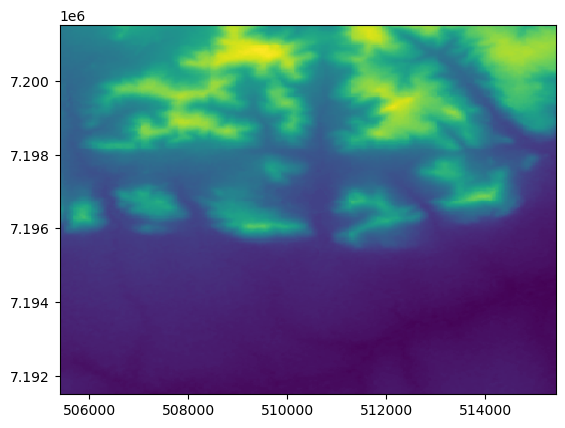

In [11]:
plt.pcolormesh(
    grid.origin["x"] + grid.cell_center_u,
    grid.origin["y"] + grid.cell_center_v,
    dem.values.reshape(grid.shape),
)

## Creating objects

The `geoh5` format supports a wide range of object types as [documented here](https://geoh5py.readthedocs.io/en/stable/content/geoh5_format/analyst/objects.html#analyst-objects). For this training, we will create a simple `Points` object using the `.create()` method.


For the `Points` to be fully defined, we need to at least assign vertices as an array of 3D coordinates `shape(*, 3)`.
Let's add one point at the Sun City resort.

In [12]:
point = Points.create(workspace, vertices=np.c_[510000, 7196500, 1150])
workspace.close()

Since we have closed workspace, you can now safely open the `suncity.geoh5` with ANALYST to see the result.

![grid2d](./images/grid2d.png)

## Example 1a: Creating data from a magnetic dipole

Now that we have an object created, we can add data to it. We will borrow
some functions from the `numpy` package to compute values on the cells of our 2D grid.

Let's start with a simple problem of computing the magnetic field due to a
dipole. This can later become a useful tool to interpret magnetic maps.

From first year physics, the magnetic field of a single dipole is:

$$\mathbf{B} = \frac{\mu_0}{4 \pi}  \frac{3 (\mathbf{m} \cdot \mathbf{r})  \mathbf{\hat r} - \mathbf{m}}{r^3}$$

where $\mu_0$ is a constant ($4 \pi 1e-9$), $\mathbf{m}$ is the magnetic dipole and $\mathbf{r}$ is the
vector separating the dipole and the observations (our grid cells).

We can first create a small function that computes the magnetic field for a single dipole.

In [13]:
def inclination_declination_2_xyz(inclination, declination):
    """Convert inclination and declination angles (degrees) to unit vector (xyz)."""
    theta = np.deg2rad((450 - inclination) % 360)
    phi = np.deg2rad(90 + declination)
    xyz = np.c_[np.sin(phi) * np.cos(theta), np.sin(phi) * np.sin(theta), np.cos(phi)]

    return xyz

def b_field(source, locations, moment, inclination, declination):
    """
    Compute the magnetic field components of a dipole on an array of locations.

    :param source: Location of a point dipole, shape(1, 3).
    :param locations: Array of observation locations, shape(n, 3).
    :param moment: Dipole moment of the source (A.m^2)
    :param inclination: Dipole horizontal angle, clockwise from North
    :param declination: Dipole vertical angle from horizontal, positive down

    :return: Array of magnetic field components, shape(n, 3)
    """
    # Convert the inclination and declination to Cartesian vector
    m = moment * inclination_declination_2_xyz(inclination, declination)

    # Compute the radial components
    rad = source - locations

    # Compute |r|
    dist = np.sum(rad**2.0, axis=1) ** 0.5

    # mu_0 / 4 pi * 1e-9 (nano)
    constant = 1e2
    fields = (
        constant
        * ((np.dot(m, rad.T).T * (rad / dist[:, None])) - m)
        / dist[:, None] ** 3.0
    )

    return fields

We can use a few array mulitplication methods from `numpy`

- The `sum()` method can be done along a specific axis of an array, collapsing the dimension.

- The `dot()` method performs the dot product between two arrays, but the shapes need to align. The transpose (`.T`) method allows us to do it inline

$[1 \times 3] \cdot [M \times 3].T \rightarrow [1 \times M] $.

- 1D-arrays can be broadcasted (repeated) along a second dimension using the `[:, None]` indexing.

$[N \times 3] \;/\;([1 \times N][: None]) \rightarrow [N \times 3] $

We can now use our function to compute the fields on the existing grid centroids.

In [14]:
moment, inclination, declination = 1.0, 90, 0
b = b_field(point.vertices, grid.centroids, moment, inclination, declination)

The `b_field` function returns an array for the three components of the magnetic field due to the dipole source. Since we normally measure Total Magnetic Intensity (TMI) data, we should project those fields onto the Earth's magnetic field.

$$
b_{TMI} \approx \mathbf{\hat H}_0 \cdot \mathbf{b}
$$

In [15]:
H = inclination_declination_2_xyz(-62.11, -17.9)  # Suncity field parameters
tmi = np.dot(H, b.T)

We then add the vector field and TMI values to our Grid2D for visualization in ANALYST.

In [16]:
with workspace.open():
    grid.add_data(
        {
            "b_x": {"values": b[:, 0]},
            "b_y": {"values": b[:, 1]},
            "b_z": {"values": b[:, 2]},
            "tmi": {"values": tmi},
        }
    )

Similarly, we can add data to the Points to show the strength and direction of the dipole moment. We are going to group those data so that we can display them as arrow in ANALYST.

In [17]:
with workspace.open():
    params = point.add_data(
        {
            "moment": {"values": np.r_[moment]},
            "inclination": {"values": np.r_[inclination]},
            "declination": {"values": np.r_[declination]},
        }
    )
    prop_group = point.find_or_create_property_group(
        name="dipole", property_group_type="Dip direction & dip"
    )
    point.add_data_to_group(params[1:], prop_group)

Et voila!

![bfield](./images/b_field.png)

For more examples on how to create other object types, visit the [geoh5py-Tutorial](https://geoh5py.readthedocs.io/en/stable/content/user_guide/core_entities.html#Entities)

## Example 1b:  Generalizing the application

A good way to write useful programs is to generalize the code such that the same functions can easily be re-used by different programs. In this section, we are going to re-purpose [Example 1a](http://localhost:8890/notebooks/geoh5_api.ipynb#Example-1a:-Creating-data-from-a-magnetic-dipole) such that the calculation can occur on any other object types supported by ANALYST.

Fortunately for us, computing the total magnetic field from many dipoles is a linear (sum) operation. Let's wrap all the previous functions into a `MagneticSimulation` class.

In [18]:
class MagneticSimulation:
    """
    Compute the magnetic field components of dipoles on a geoh5py object.

    :param dipoles: Array or Points object of dipole locations, shape(m, 3).
    :param locations: Array or Points object of observation locations, shape(n, 3).
    :param moments: Value or Data of dipole moments.
    :param inclinations: Value or Data of dipole inclination angles.
    :param declinations: Value or Data of dipole declination angles.

    :return b_field: Vector array of magnetic field components, shape(n ,3).
    """

    def __init__(
        self,
        sources: Points,
        receivers: ObjectBase,
        moments: Data | float,
        inclinations: Data | float,
        declinations: Data | float,
        earth_field=(90.0, 0),
    ):
        self._sources = sources
        self._receivers = receivers
        self._moments = moments
        self._inclinations = inclinations
        self._declinations = declinations
        self._earth_field = earth_field

    @property
    def sources(self):
        if hasattr(self._sources, "centroids"):
            return self._sources.centroids
        return self._sources.vertices

    @property
    def receivers(self):
        if hasattr(self._receivers, "centroids"):
            return self._receivers.centroids
        return self._receivers.vertices

    @property
    def moments(self):
        if isinstance(self._moments, Data):
            return self._moments.values
        if isinstance(self._moments, float):
            return np.ones(self.sources.shape[0]) * self._moments

        return self._moments

    @property
    def inclinations(self):
        if isinstance(self._inclinations, Data):
            return self._inclinations.values
        if isinstance(self._inclinations, float):
            return np.ones(self.sources.shape[0]) * self._inclinations

        return self._inclinations

    @property
    def declinations(self):
        if isinstance(self._declinations, Data):
            return self._declinations.values
        if isinstance(self._declinations, float):
            return np.ones(self.sources.shape[0]) * self._declinations

        return self._declinations

    def compute(self):
        """Compute fields from input."""
        fields = np.zeros_like(self.receivers)

        for source, moment, inclination, declination in zip(
            self.sources, self.moments, self.inclinations, self.declinations
        ):
            fields += b_field(source, self.receivers, moment, inclination, declination)

        return fields

    def tmi_projection(self, fields):
        """Project magnetic field onto Earth's field."""
        H = inclination_declination_2_xyz(
            self._earth_field[0], self._earth_field[1]
        )  # Suncity field parameters
        return np.dot(H, fields.T)

    def run(self):
        """Run the simulation and save."""
        with self._receivers.workspace.open(mode="r+"):
            fields = self.compute()
            tmi = self.tmi_projection(fields)
            data = self._receivers.add_data(
                {
                    "b_x": {"values": fields[:, 0]},
                    "b_y": {"values": fields[:, 1]},
                    "b_z": {"values": fields[:, 2]},
                    "tmi": {"values": tmi},
                }
            )

        return data

We now have a generic container to compute TMI data based on any type of ANALYST object.

You are now invited to edit your Points object to add more vertices and create data arrays for moment, azimuth and dips. We can now run the simulation by simply giving those entities to our class.

In [19]:
simulator = MagneticSimulation(point, grid, 1.0, 90.0, 0.0, earth_field=(-62.11, -17.9))
simulator.run()

 Copyright (c) 2022 Mira Geoscience Ltd.